In [1]:
%matplotlib inline

# 592B, Class 5.2 (02/22).  The Fourier Transform in Action

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile 
import librosa
from scipy import fftpack #new
from scipy import signal

from ipywidgets import interactive
from IPython.display import Audio, display

## Review questions

Remember the Fourier series of the square wave you computed? Grab that code and define the square wave approximation as a Fourier series for $N=6$ as you did in Problem Set 2, and plot your square wave approximation.

Draw the expected spectrum by hand.

---

Last time we ended up with the Fourier transform, expressed as a double integral:

\begin{equation}
g(t) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}e^{-2\pi ift}g(t)dt e^{2\pi ift}df
\end{equation}

and then we said you could rewrite it using the inverse Fourier Transform $G(f)$

\begin{equation}
G(f) = \int_{-\infty}^{\infty}e^{-2\pi ift} g(t)dt      
\end{equation}

and the inverse Fourier Transform

\begin{equation}
g(t) = \int_{-\infty}^{\infty}e^{2\pi ift} G(f)df      
\end{equation}

Show that $g(t)$ rewritten in terms of $G(f)$ is the same as the $g(t)$ written out as a double integral.  

---

Today we'll be having some fun with Fourier transforms, after all the hard work of mathematically deriving Fourier series and transforms. We'll be getting acquainted with [`scipy.fftpack`](https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html). A good portion of this notebook is inspired by [this fantastic chapter of **Elegant SciPy**](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html).

## The Fourier Transform in action: a first look

Remember this function?

$$y(t) = \cos \left(\frac{9\pi}{2}t\right ) $$

We worked with it when we were studying aliasing. Let's sample it at 20 Hz, for a duration of 20 seconds.

Text(0.5,1,'A familiar signal')

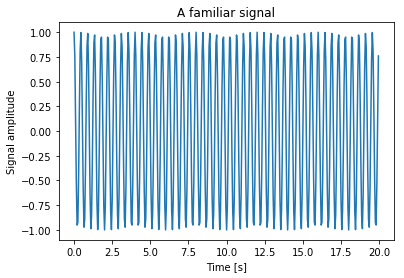

In [3]:
fs = 20 # Sampling rate of 20 Hz
t_start = 0; t_stop = 20
ns = int((t_stop - t_start) * fs)
t = np.linspace(t_start,t_stop,ns, endpoint=False)
x = np.cos(9/2*np.pi*t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude')
plt.title("A familiar signal")

Now let's take the Fourier Transform of the signal!

Text(0,0.5,'Fourier transform of signal')

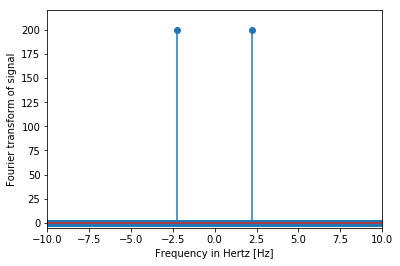

In [4]:
X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * fs

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Magnitude')
ax.set_xlim(-fs/2, fs/2)
ax.set_ylim(-5, 220)
ax.set_ylabel('Fourier transform of signal')

We end up with non-zero values at only -2.25 and 2.25 Hz. At the moment, let's not worry about why we also get negative frequencies. 

---
***Discussion: why set the x-axis limits as [-fs/2,fs/2]?***

***Discussion: does it make sense that we're getting a peak at 2.5 Hz?***

---

***In-class exercise: what happens to the computed spectrum if you delete `endpoint=False` in the np.linspace command? Why? ***

---

***In-class exercise: repeat what we did above for the signal sampled at 10 Hz. What happens and why?***

---

### Again, a bit more slowly...

Let's walk through this step-by-step. Now let's define a complex wave with two components.

In [13]:
fs = 100
t_stop = 10
t = np.linspace(0,t_stop, t_stop*fs, endpoint=False)
f1 = 5; f2= 2
x = 0.1 * np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t) + 50

Let's take the Fourier Transform and inspect the values we get.

In [14]:
X = fftpack.fft(x)

print(X[0:5])
print(len(X))

#plt.stem(X)

[  5.00000000e+04 +0.00000000e+00j   4.60893380e-15 -2.36665775e-14j
   1.51412688e-15 -1.59305336e-14j  -3.81791324e-14 -7.69581846e-15j
  -1.74958339e-14 +3.47472889e-14j]
1000


Aha! We are getting **complex** values! 

What we actually plot in the spectrum turns out to be the size of a complex number, its **modulus**, defined as:

$$Mod(a+bi) = \sqrt{a^2+b^2}$$

In python, we can work with complex numbers as follows:

In [31]:
c = complex(3,4) # syntax: complex(a,b) for defining a+bi
print(c)
print(c.real) # the real component, a
print(c.imag) # the imaginary component, b
print(np.abs(c)) # the modulus

(3+4j)
3.0
4.0
5.0


So let's try plotting the Fourier transform again, this time plotting the modulus.

[  5.00000000e+04   2.41111833e-14   1.60023274e-14   3.89470380e-14
   3.89034483e-14]


<Container object of 3 artists>

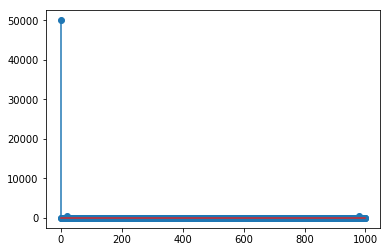

In [32]:
print(np.abs(X[0:5]))
plt.stem(np.abs(X))

But there are still some problems. First the x-axis is in terms of points. We have 1000 points, so we get an x-axis going up to 1000. How do we get this in terms of frequency? We need to set the x-axis to go from [$-f_{Nyquist}, f_{Nyquist}$], $\Delta f_s$ apart. This is where `fftpack.fftfreq` comes in. 

***Discussion: What do you notice about the array `freqs`? How long is it? What numbers does it range over? How far are the numbers apart?***


In [29]:
freqs = fftpack.fftfreq(len(x)) * fs
print(freqs)

[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9  15.   15.1  15.2  15.3  15.4  15.5
  15.6  15.7  15.8  15.9  16.   16.1  16.2  16.3  1

OK, now we're set!  

Text(0,0.5,'Fourier transform of signal')

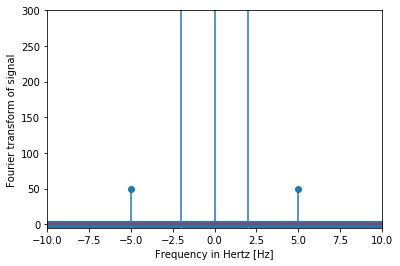

In [39]:
fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Magnitude')
#ax.set_xlim(-fs/2, fs/2)
ax.set_xlim(-10, 10)
ax.set_ylim(-5, 300)
ax.set_ylabel('Fourier transform of signal')


***In-class exercise: Fourier transform of a square wave. Compute a spectrum for the square wave you defined in the Review Questions.***

---

## From spectrum to spectrogram

Let's have some fun with [Japanese vowels](http://www.phonetics.ucla.edu/course/chapter9/japanese/japanese.html) from soundfiles collected by Peter Ladefoged. First we'll use `librosa` to load an audio recording of [ma]. And just for kicks, let's listen to it resampled at different sampling rates.

In [ ]:
y, sr = librosa.load("ma.aiff", sr = None)
print(type(y)) # Note that it is a numpy array
print("The sampling rate is: ", sr, "Hz")


y_8k = librosa.resample(y, sr, 8000)
y_2k = librosa.resample(y, sr, 2000)
y_500 = librosa.resample(y, sr, 500)

display(Audio(data=y,rate = sr))
display(Audio(data=y_8k,rate = 8000))
display(Audio(data=y_2k,rate = 2000))
display(Audio(data=y_500,rate = 500))


---
***In-class exercise: compute the spectrum of [a] in the recording.***

1. Plot the waveform, and use the waveform to determine what part of the recording has a steady-state [a]. 
2. Now that you've determined that, work with just that portion of the signal for computing the spectrum.
3. Try computing the spectrum for the [a] sampled at different sampling rates. How does this affect what you see in the resulting spectrum, if at all?
4. Do your computed spectra look as expected, given what you know about formants? You might try computing spectra for the other vowel samples at the webpage, too, e.g., [o], [i], etc.

---

Now let's work towards computing the spectrogram for the audio file. First let's plot the waveform of the audio file.

***Discussion: do you notice a technical problem with the recording revealed from plotting the waveform?***

In [ ]:
N = y.shape[0]
L = N / sr

print(f'Audio length: {L:.2f} seconds')

f, ax = plt.subplots()
ax.plot(np.arange(N) / sr, y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [unknown]');

We can compute a spectrogram using [spectral analysis tools provided by `scipy.signal`](https://github.com/scipy/scipy/blob/master/scipy/signal/spectral.py), namely, `scipy.signal.spectrogram`.

In [ ]:
help(signal.spectrogram)

We can use the example code from the help file to try to compute the spectrogram for [ma].

***Discussion: Does the spectrogram look as you expect? Fiddle with the settings of the plot as suits you. Also try using the code from [Elegant SciPy](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) used to produce figure 4-4. How does that look? Compare your computed spectrograms to the ones you get when you analyze the [ma] file in Praat.***

In [ ]:
f,t, Sxx = signal.spectrogram(y,sr)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

To better understand how scipy.signal.spectrogram works, let's look at how it is defined. We can do this [using the `inspect` module](https://stackoverflow.com/questions/427453/how-can-i-get-the-source-code-of-a-python-function#427533). We can also look at [the code on github](https://github.com/scipy/scipy/blob/master/scipy/signal/spectral.py), which is a little prettier.

In [ ]:
import inspect
lines = inspect.getsourcelines(signal.spectrogram)
print("".join(lines[0]))

Well that's not that helpful. Looks like we need to take a look at `signal._spectral_helper`, which we can look at in the github code.

In [ ]:
# This doesn't work!
#lines = inspect.getsourcelines(signal.spectral_helper)
#print("".join(lines[0]))

Now let's use the code from [Elegant Scipy](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) used to produce Figure 4.3, which breaks down spectrogram computation step by step.

In [ ]:
from skimage import util

M = 1024

slices = util.view_as_windows(y, window_shape=(M,), step=100)
print(f'Audio shape: {y.shape}, Sliced audio shape: {slices.shape}')

win = np.hanning(M + 1)[:-1]
slices = slices * win

slices = slices.T
print('Shape of `slices`:', slices.shape)

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

In [ ]:
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, sr / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

## Working through DFT, FFT

Finally, let's work through the [Elegant Scipy](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) material on DFT and FFT together. This is the section that starts after Figure 4.4.